Created a 11-dimensional hypercube with 2048 nodes.
Step 1: Completed single sparse LU factorization of the Laplacian minor.
Step 2: Computing effective resistances...
Step 3: Solved for final costs (voltages).

--- Results ---
The expected maximum cost for a random walk on this graph is: 1030.8238
For reference, the average cost is (N-1)/2 = 1023.5000


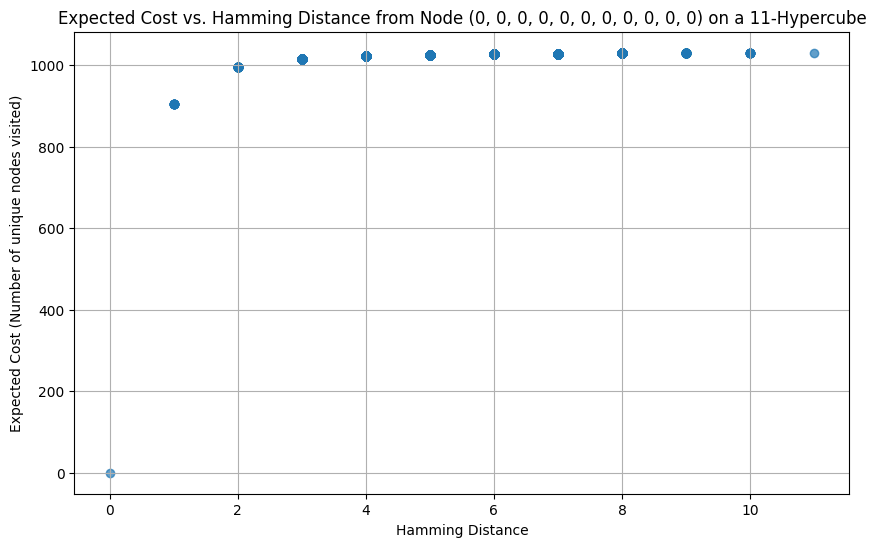

In [ ]:
import networkx as nx
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# --- 1. Setup and Graph Creation ---
# Define the dimension of the hypercube
d = 11
N = 2**d  # Total number of nodes

# Create the hypercube graph using networkx
G = nx.hypercube_graph(d)
print(f"Created a {d}-dimensional hypercube with {N} nodes.")

# ROBUSTNESS FIX: Generate the nodelist directly from the graph object
# to ensure it perfectly matches the nodes that actually exist in G.
nodelist = sorted(list(G.nodes()))

# Get the graph Laplacian matrix, ensuring the row/column order matches our list.
L = nx.laplacian_matrix(G, nodelist=nodelist).astype(np.float64)

# --- 2. Implement the "Single-Factor" Cost Calculation Method ---
# Choose a target (or "sink") node 'v'. We'll use the first node in our sorted list.
v_target = nodelist[0]
minor_nodes_indices = [i for i, node in enumerate(nodelist) if node != v_target]
minor_nodes_labels = [node for node in nodelist if node != v_target]


# Create the minor of the Laplacian by removing the row and column
# corresponding to the target node 'v_target'.
L_minor = L[minor_nodes_indices, :][:, minor_nodes_indices]


# Factorize L_minor *once* using a sparse LU decomposition.
lu_factor = spla.splu(L_minor.tocsc())
print("Step 1: Completed single sparse LU factorization of the Laplacian minor.")


# --- 3. Compute Effective Resistances ---
effective_resistances = np.zeros(N - 1)
print("Step 2: Computing effective resistances...")

# We now iterate using the indices of the minor matrix
for i in range(N - 1):
    # Create the standard basis vector e_x
    e_x = np.zeros(N - 1)
    e_x[i] = 1.0

    # Solve the system using the pre-computed LU factorization
    y = lu_factor.solve(e_x)

    # The effective resistance is the diagonal entry of the inverse of the minor
    effective_resistances[i] = y[i]

# --- 4. Assemble Current Vector and Solve for Voltages (Costs) ---
# Assemble the "current" vector b
b = 1.0 / effective_resistances

# Solve the final linear system L_minor * phi = b to get the voltages (costs).
phi_costs = lu_factor.solve(b)
print("Step 3: Solved for final costs (voltages).")

# The full cost array includes the cost from the target to itself, which is 0.
all_costs = np.zeros(N)
# Place the calculated costs into the correct positions in the full array
all_costs[minor_nodes_indices] = phi_costs

# --- 5. Find and Report the Maximum Cost ---
max_cost = np.max(all_costs)

print("\n--- Results ---")
print(f"The expected maximum cost for a random walk on this graph is: {max_cost:.4f}")
print(f"For reference, the average cost is (N-1)/2 = {(N-1)/2:.4f}")


# --- 6. (Optional) Plot Cost vs. Hamming Distance ---
# CORRECTED FUNCTION: This version handles tuple-based node labels
# by comparing elements at each position.
def hamming_distance(t1, t2):
    return sum(1 for i, j in zip(t1, t2) if i != j)

distances = [hamming_distance(v_target, node) for node in nodelist]

plt.figure(figsize=(10, 6))
plt.scatter(distances, all_costs, alpha=0.7)
plt.title(f'Expected Cost vs. Hamming Distance from Node {v_target} on a {d}-Hypercube')
plt.xlabel('Hamming Distance')
plt.ylabel('Expected Cost (Number of unique nodes visited)')
plt.grid(True)
plt.show()